In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import pickle
%matplotlib inline

In [6]:
dst_dir = "../data/sealion/Train2x"
src_dir = "../data/sealion/Train"

In [6]:
os.makedirs(dst_dir)

In [7]:
scale = 2
fns = os.listdir(src_dir)
with progressbar.ProgressBar(min_value=0, max_value=len(fns)) as pbar:
    for i, fn in enumerate(fns):
        im_fn = os.path.join(src_dir, fn)
        im = cv2.imread(im_fn)
        if im is not None:
            h, w, c = im.shape
            im_resized = cv2.resize(im, (w//scale, h//scale), interpolation=cv2.INTER_LINEAR)
            cv2.imwrite(os.path.join(dst_dir, fn), im_resized)
        pbar.update(i)

100% (949 of 949) |#######################| Elapsed Time: 0:10:51 Time: 0:10:51


In [ ]:
def split_in_blocks(im_raw, dmap, n_blocks=(4,4), overlap=(448,448)):
    h, w = im_raw.shape[:2]
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    
    if (w + (n_blocks[1] - 1) * overlap[1]) % n_blocks[1] != 0 or \
        (h + (n_blocks[0] - 1) * overlap[0]) % n_blocks[0] != 0:
            print("Warning: check the number of blocks and overlap")
            
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            yield im_raw[y_start:y_end, x_start:x_end,...], dmap[y_start:y_end, x_start:x_end,...]

In [8]:
def merge_smap_blocks(image_id, src_dir, shape_dir, n_blocks=(4,4), overlap=(448,448)):
    nb = n_blocks[0] * n_blocks[1]
    with open(os.path.join(shape_dir, str(image_id) + ".pkl"), "rb") as pfile:
        shape = pickle.load(pfile)
        
    h, w = shape
    smap_merged = np.zeros((h, w), dtype=np.uint8)
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    
    b = 0
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            smap = np.load(os.path.join(src_dir, "{iid}_{bid}.npz".format(iid=image_id, bid=b)))["smap"]
            smap_merged[y_start:y_end, x_start:x_end,...] = smap
            b += 1
    return smap_merged
    

In [29]:
os.makedirs("../data/sealion/TrainSegmentationIgnored2x", exist_ok=True)

In [32]:
scale = 2
fns = os.listdir(dst_dir)
with progressbar.ProgressBar(min_value=0, max_value=len(fns)) as pbar:
    for i, fn in enumerate(fns):
        iid, _ = os.path.splitext(fn)
        iid = int(iid)
        
        smap = merge_smap_blocks(iid, "../data/sealion/TrainSegmentationIgnoredBlock/", "../data/sealion/TrainShape/")
        h, w = smap.shape
        smap_resized = cv2.resize(smap, (w//scale, h//scale), interpolation=cv2.INTER_NEAREST)
        np.savez(os.path.join("../data/sealion/TrainSegmentationIgnored2x", str(iid) + ".npz"), smap=smap_resized)
        pbar.update(i)

100% (948 of 948) |#######################| Elapsed Time: 0:07:51 Time: 0:07:51


In [2]:
smap = np.load("../data/sealion/TrainSegmentationIgnored2x/0.npz")["smap"]

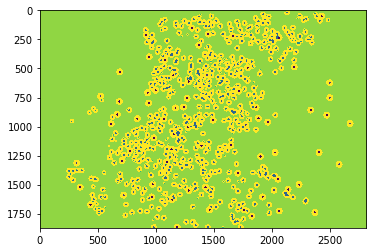

In [3]:
plt.imshow(smap)

In [2]:
os.makedirs("../data/sealion/TrainSegmentationIgnored2xB", exist_ok=True)

In [9]:
scale = 2
fns = os.listdir(dst_dir)
with progressbar.ProgressBar(min_value=0, max_value=len(fns)) as pbar:
    for i, fn in enumerate(fns):
        iid, _ = os.path.splitext(fn)
        iid = int(iid)
        
        smap = merge_smap_blocks(iid, "../data/sealion/TrainSegmentationIgnoredBlockB/", "../data/sealion/TrainShape/")
        h, w = smap.shape
        smap_resized = cv2.resize(smap, (w//scale, h//scale), interpolation=cv2.INTER_NEAREST)
        np.savez(os.path.join("../data/sealion/TrainSegmentationIgnored2xB", str(iid) + ".npz"), smap=smap_resized)
        pbar.update(i)

100% (948 of 948) |#######################| Elapsed Time: 0:07:20 Time: 0:07:20


In [25]:
smap = np.load("../data/sealion/TrainSegmentationIgnored2xB/0.npz")["smap"]
im = cv2.imread("../data/sealion/Train2x/0.jpg")

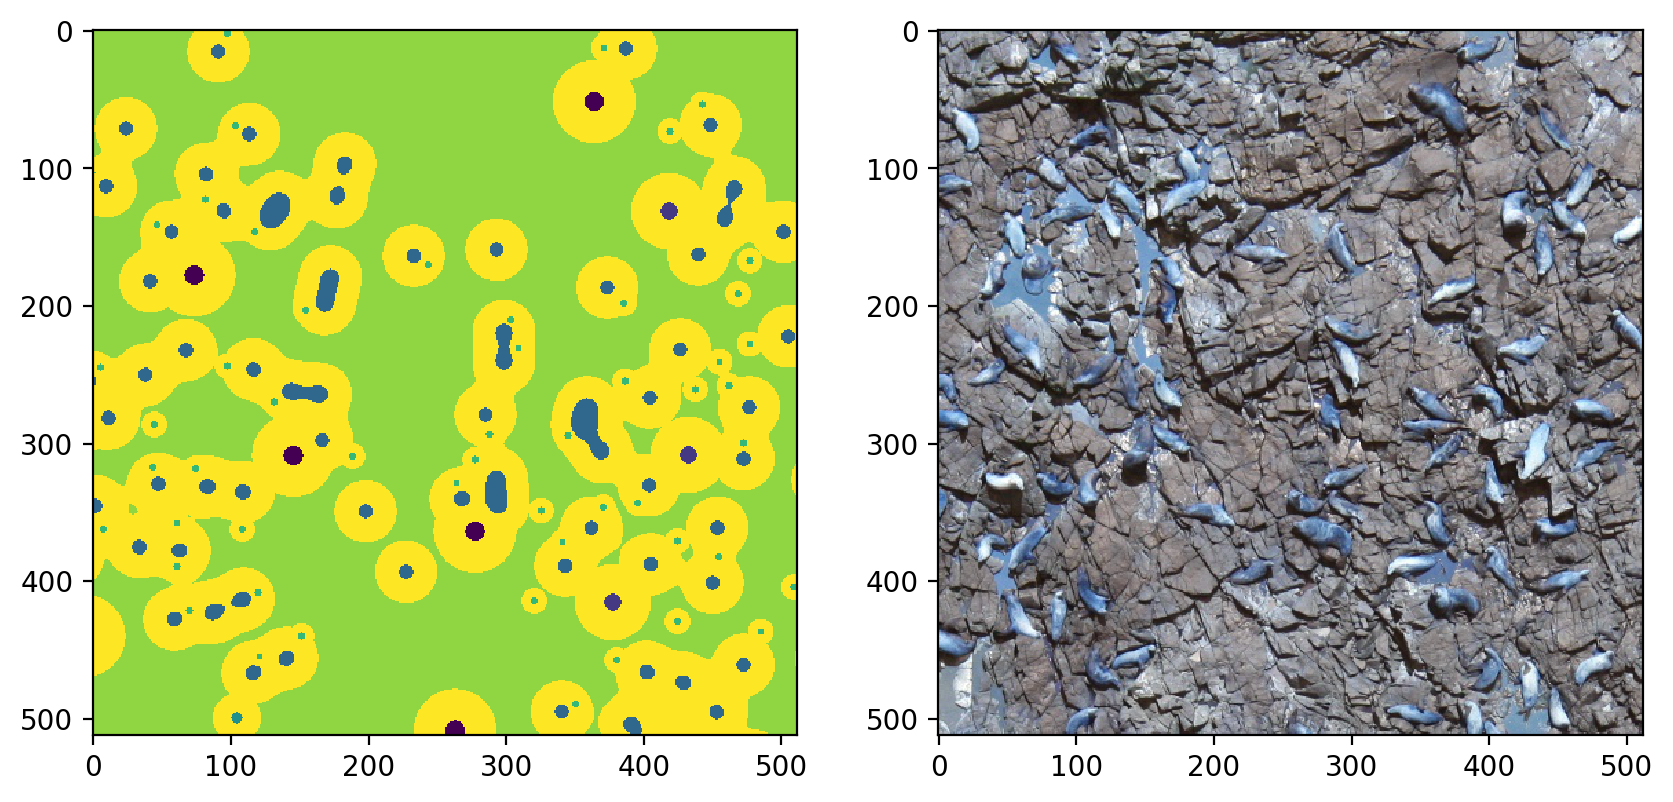

In [26]:
fig = plt.figure(figsize=(10, 20), dpi=200)
plt.subplot(121)
plt.imshow(smap[250:250+512, 1000:1000+512])
plt.subplot(122)
plt.imshow(im[250:250+512, 1000:1000+512, ...])